In [1]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
dataframe = pd.read_csv("SP500DATA.csv")
print(dataframe)# Text file data converted to integer data type

           Date    Price     Open     High      Low Vol.  Change %
0    01/12/2021  4766.18  4623.80  4808.52  4494.20    -    0.0436
1    01/11/2021  4567.00  4616.47  4743.74  4560.26    -   -0.0083
2    01/10/2021  4605.38  4324.71  4608.70  4278.70    -    0.0691
3    01/09/2021  4307.54  4531.04  4544.58  4304.90    -   -0.0476
4    01/08/2021  4522.68  4415.90  4537.80  4369.20    -    0.0290
..          ...      ...      ...      ...      ...  ...       ...
618  01/06/1970    72.72    76.55    79.96    72.25    -   -0.0500
619  01/05/1970    76.55    81.52    82.32    68.61    -   -0.0610
620  01/04/1970    81.52    89.63    90.70    79.31    -   -0.0905
621  01/03/1970    89.63    89.50    91.07    86.19    -    0.0015
622  01/02/1970    89.50    85.02    90.33    84.64    -    0.0527

[623 rows x 7 columns]


# Step 1

In [2]:
trainData = dataframe[["Price", "Open"]].to_numpy(dtype = 'float')
targetData = dataframe[["Price"]].to_numpy(dtype = 'float')
date = dataframe[["Date"]].to_numpy(dtype = "str")

norm = MinMaxScaler(feature_range = (0, 1))
trainData = norm.fit_transform(trainData)
targetData = norm.fit_transform(targetData)
trainData = np.flip(trainData)
targetData = np.flip(targetData)
date = np.flip(date)

dateAxis = []
for i in range(date.shape[0]):
    dateAxis.append(float(np.squeeze(date)[i][6:10]) + float(np.squeeze(date)[i][3:5])/12.0)
dateAxis = np.array(dateAxis)
dateAxis_test=date[438:623,:]
dateAxis = dateAxis[6:620]
print(dateAxis.shape)

(614,)


In [3]:
X = []
Y = []
for i in range(trainData.shape[0] - 5 - 4):
    X.append(trainData[i:i+6])
    Y.append(targetData[i+6:i+6+4])
X = np.array(X)
Y = np.array(Y)
Y = np.swapaxes(Y, 1, 2)
Y.shape

(614, 1, 4)

In [4]:
X_fullTraining = []
X_training = []
X_validation = []
X_test = []
Y_fullTraining = []
Y_training = []
Y_validation = []
Y_test = []

X_fullTraining, X_test, Y_fullTraining, Y_test, date_ft, date_t = train_test_split(X, Y, dateAxis, test_size=0.3, shuffle=False)
X_training, X_validation, Y_training, Y_validation, date_tr, date_v = train_test_split(X_fullTraining, Y_fullTraining, date_ft, test_size=0.3, shuffle=False)

date_test=date[438:623,:]

# Step 2

In [5]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   

        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        hidden = self.init_hidden(batch_size)

        out, hidden = self.rnn(x, hidden)
    
        out = self.fc(out)
    
        return out[:, -1, :], hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [6]:
RNN = Model(input_size=2, output_size=4, hidden_dim=16, n_layers=1)
optimizer = torch.optim.Adam(RNN.parameters(), lr=0.01)
criterion = nn.MSELoss()
RNN

Model(
  (rnn): RNN(2, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=4, bias=True)
)

# Step 3

In [7]:
xTensor = torch.from_numpy(X_fullTraining).float()
yTensor = torch.Tensor(Y_fullTraining).float()

for epoch in range(100):
    optimizer.zero_grad()
    
    output, hidden = RNN(xTensor)
    loss = criterion(output.reshape(-1), yTensor.view(-1))
    loss.backward()
    
    optimizer.step()
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, 100), end=' ')
        print("Loss:", loss.item())

Epoch: 0/100............. Loss: 0.09395692497491837
Epoch: 10/100............. Loss: 0.008558538742363453
Epoch: 20/100............. Loss: 0.003936051391065121
Epoch: 30/100............. Loss: 0.0010145516134798527
Epoch: 40/100............. Loss: 0.00018863049626816064
Epoch: 50/100............. Loss: 0.0001963344548130408
Epoch: 60/100............. Loss: 0.0001497706980444491
Epoch: 70/100............. Loss: 0.00011351885768817738
Epoch: 80/100............. Loss: 0.00010181832476519048
Epoch: 90/100............. Loss: 9.97336464934051e-05


In [8]:
def prediction_error(pred, actual):
    return abs(pred - actual)/pred

In [9]:
output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_plt = norm.inverse_transform(Y[:, :, 0])
Y_fullTrainingplt = norm.inverse_transform(Y_fullTraining[:, :, 0])

Mean   STD-dev  Skewness  Kurtosis
1 day  0.047099  0.041118  1.699901  4.648245
2 day  0.045631  0.039952  1.708226  4.691541
3 day  0.069458  0.057435  1.068311  1.131465
4 day  0.072193  0.059711  0.997704  0.803180

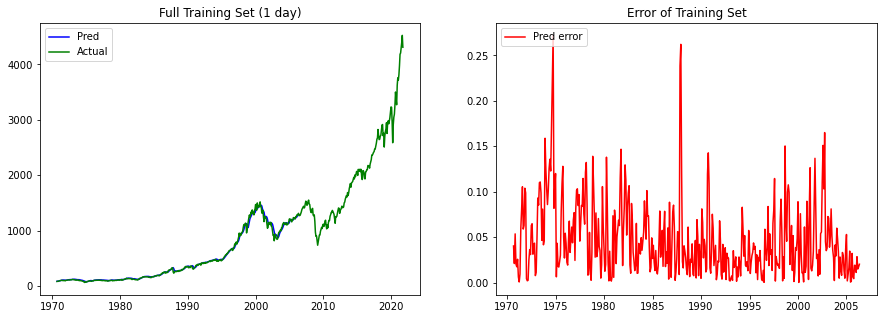

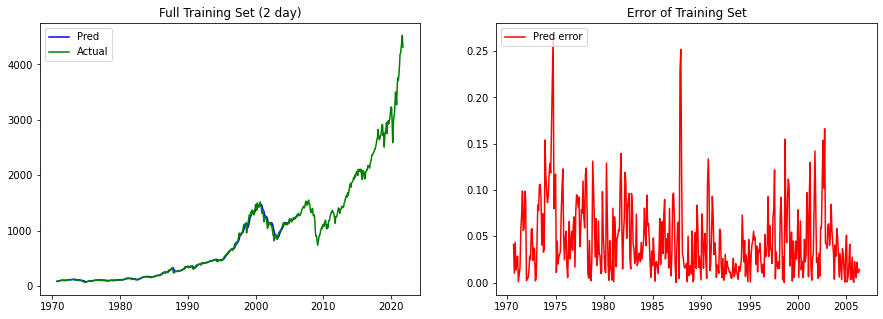

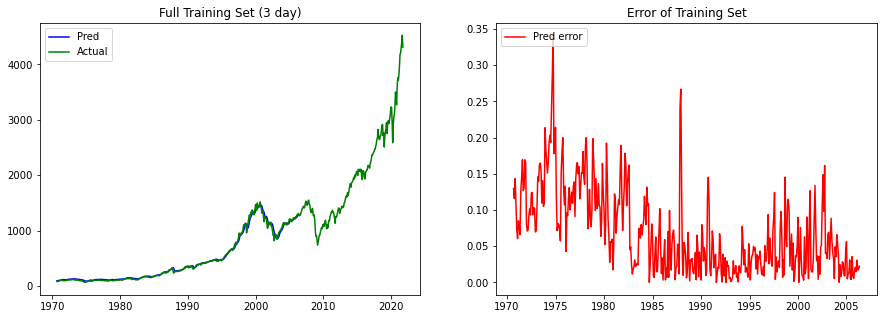

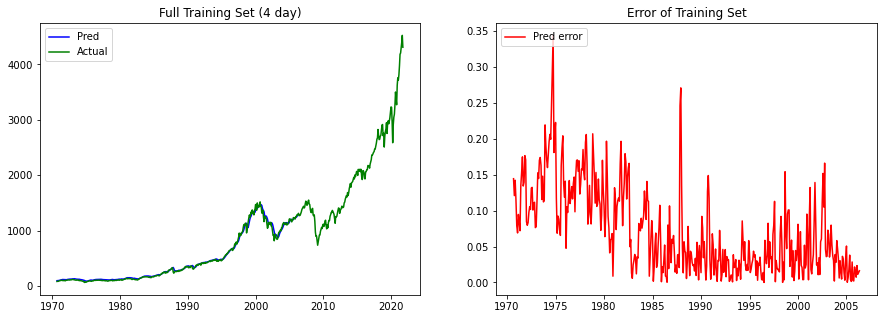

In [10]:
table = []

error = prediction_error(output_plt1, Y_fullTrainingplt)
error_dt = pd.DataFrame(data = error)
temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp1 = np.array(temp1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Full Training Set (1 day)")
ax1.plot(date_ft, output_plt1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_ft, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt2, Y_fullTrainingplt)
error_dt = pd.DataFrame(data = error)
temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp2 = np.array(temp2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Full Training Set (2 day)")
ax1.plot(date_ft, output_plt2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_ft, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt3, Y_fullTrainingplt)
error_dt = pd.DataFrame(data = error)
temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp3 = np.array(temp3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Full Training Set (3 day)")
ax1.plot(date_ft, output_plt3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_ft, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt4, Y_fullTrainingplt)
error_dt = pd.DataFrame(data = error)
temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp4 = np.array(temp4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Full Training Set (4 day)")
ax1.plot(date_ft, output_plt4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_ft, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

temp1 = np.expand_dims(temp1, axis=1)
temp2 = np.expand_dims(temp2, axis=1)
temp3 = np.expand_dims(temp3, axis=1)
temp4 = np.expand_dims(temp4, axis=1)
table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
col = ['1 day', '2 day', '3 day', '4 day']
stats=pd.DataFrame(table, columns=col, index=ind).T
stats

# Step 4 

In [11]:
RNN.eval()
xTensor = torch.from_numpy(X_test).float()
output, _ = RNN(xTensor)

output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_testplt = norm.inverse_transform(Y_test[:, :, 0])

Mean   STD-dev  Skewness  Kurtosis
1 day  0.101875  0.091924  1.570125  2.231216
2 day  0.073166  0.063158  1.520833  1.886327
3 day  0.094970  0.084759  1.651360  2.564733
4 day  0.086932  0.079382  1.652133  2.482663

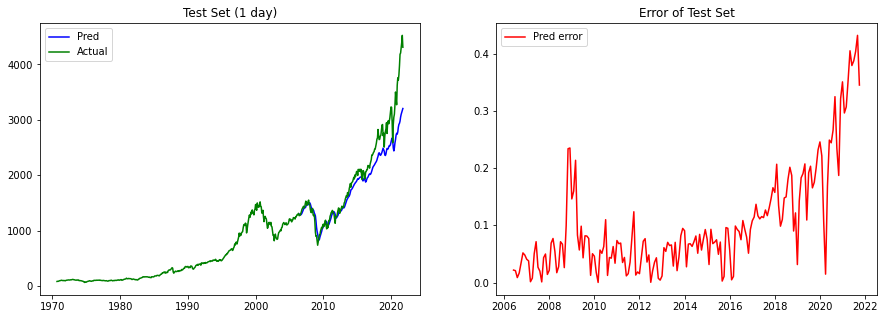

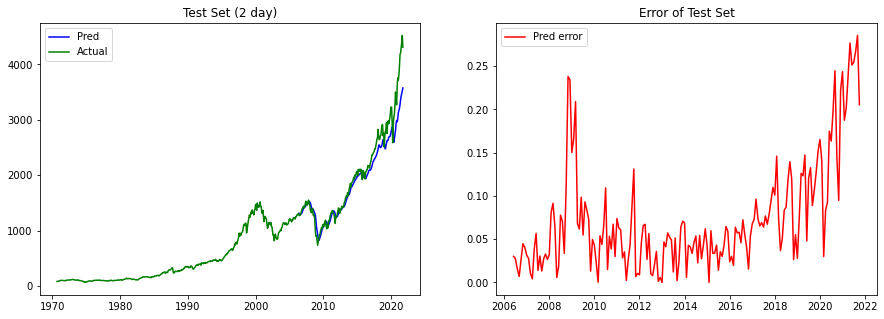

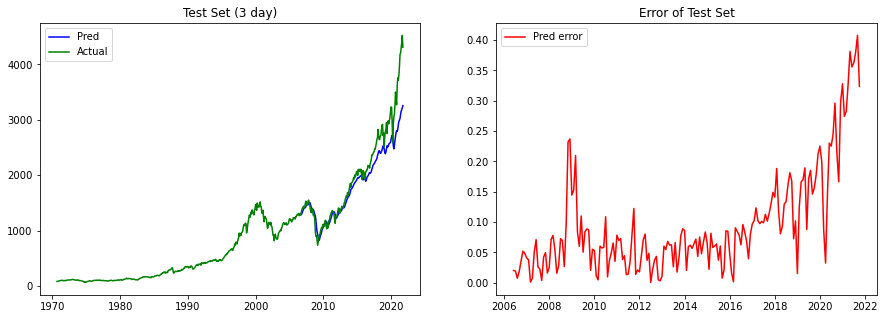

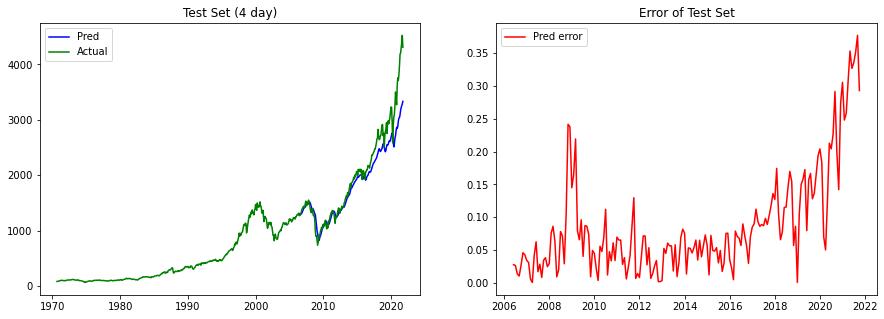

In [12]:
table = []

error = prediction_error(output_plt1, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp1 = np.array(temp1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (1 day)")
ax1.plot(date_t, output_plt1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt2, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp2 = np.array(temp2)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (2 day)")
ax1.plot(date_t, output_plt2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt3, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp3 = np.array(temp3)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (3 day)")
ax1.plot(date_t, output_plt3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt4, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp4 = np.array(temp4)
                  
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (4 day)")
ax1.plot(date_t, output_plt4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")


temp1 = np.expand_dims(temp1, axis=1)
temp2 = np.expand_dims(temp2, axis=1)
temp3 = np.expand_dims(temp3, axis=1)
temp4 = np.expand_dims(temp4, axis=1)
table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
col = ['1 day', '2 day', '3 day', '4 day']
stats=pd.DataFrame(table, columns=col, index=ind).T
stats

# Step 5

In [13]:
RNNval = Model(input_size=2, output_size=4, hidden_dim=32, n_layers=2)
optimizerVal = torch.optim.Adam(RNNval.parameters(), lr=0.002)
criterionVal = nn.MSELoss()
RNNval

xTensor = torch.from_numpy(X_training).float()
yTensor = torch.Tensor(Y_training).float()

for epoch in range(200):
    optimizerVal.zero_grad()
    
    output, hidden = RNNval(xTensor)
    loss = criterionVal(output.reshape(-1), yTensor.view(-1))
    loss.backward()
    
    optimizerVal.step()
    
    if epoch%100 == 0:
        print('Epoch: {}/{}.............'.format(epoch, 200), end=' ')
        print("Loss:", loss.item())

Epoch: 0/200............. Loss: 0.011407396756112576
Epoch: 100/200............. Loss: 2.172421409341041e-05


In [14]:
output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_plt = norm.inverse_transform(Y[:, :, 0])
Y_trainingplt = norm.inverse_transform(Y_training[:, :, 0])

Mean   STD-dev  Skewness  Kurtosis
1 day  0.053724  0.045136  1.542477  3.847967
2 day  0.052865  0.043989  1.637906  4.664849
3 day  0.051660  0.042476  1.798587  5.740493
4 day  0.056044  0.044924  1.711214  5.093887

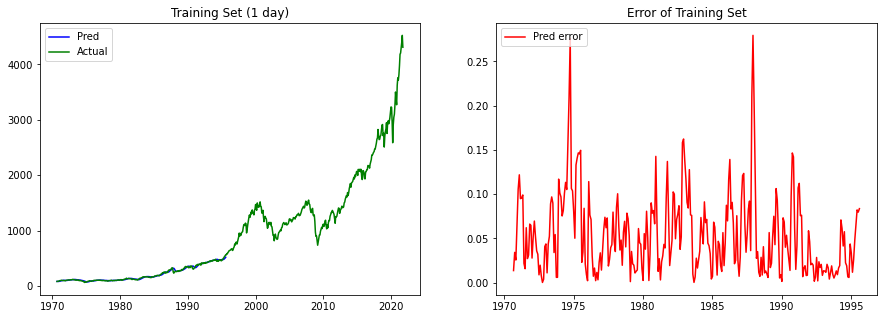

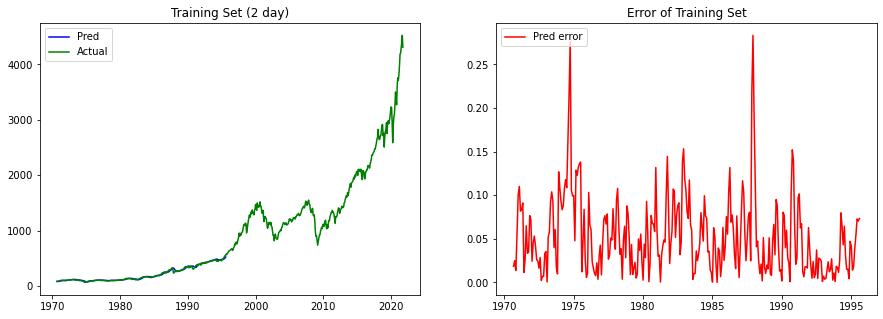

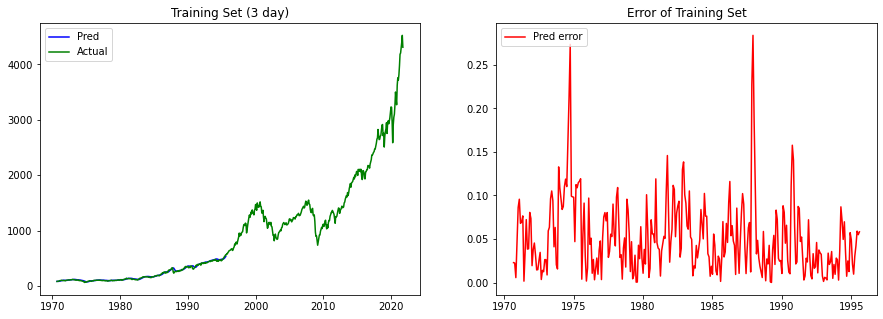

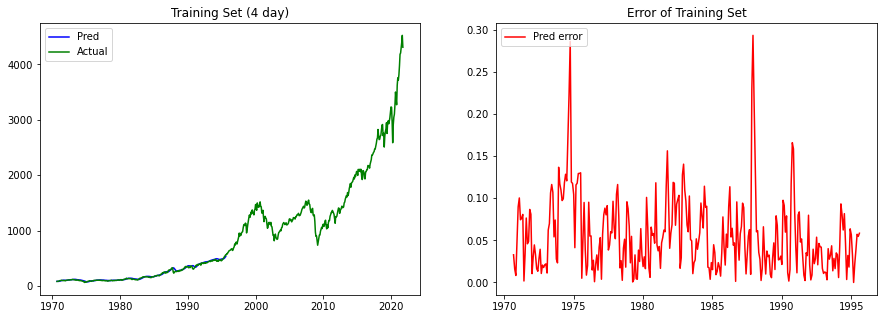

In [15]:
table = []

error = prediction_error(output_plt1, Y_trainingplt)
error_dt = pd.DataFrame(data = error)
temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp1 = np.array(temp1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Training Set (1 day)")
ax1.plot(date_tr, output_plt1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_tr, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt2, Y_trainingplt)
error_dt = pd.DataFrame(data = error)
temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp2 = np.array(temp2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Training Set (2 day)")
ax1.plot(date_tr, output_plt2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_tr, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt3, Y_trainingplt)
error_dt = pd.DataFrame(data = error)
temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp3 = np.array(temp3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Training Set (3 day)")
ax1.plot(date_tr, output_plt3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_tr, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt4, Y_trainingplt)
error_dt = pd.DataFrame(data = error)
temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp4 = np.array(temp4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Training Set (4 day)")
ax1.plot(date_tr, output_plt4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_tr, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")


temp1 = np.expand_dims(temp1, axis=1)
temp2 = np.expand_dims(temp2, axis=1)
temp3 = np.expand_dims(temp3, axis=1)
temp4 = np.expand_dims(temp4, axis=1)
table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
col = ['1 day', '2 day', '3 day', '4 day']
stats=pd.DataFrame(table, columns=col, index=ind).T
stats

In [16]:
RNNval.eval()
xTensor = torch.from_numpy(X_validation).float()
output, _ = RNNval(xTensor)

output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_validationplt = norm.inverse_transform(Y_validation[:, :, 0])

Mean   STD-dev  Skewness  Kurtosis
1 day  0.081286  0.045172  0.581588  0.018219
2 day  0.065200  0.040314  0.766299  0.310634
3 day  0.064634  0.039315  0.797884  0.263118
4 day  0.071193  0.043418  0.683821  0.073860

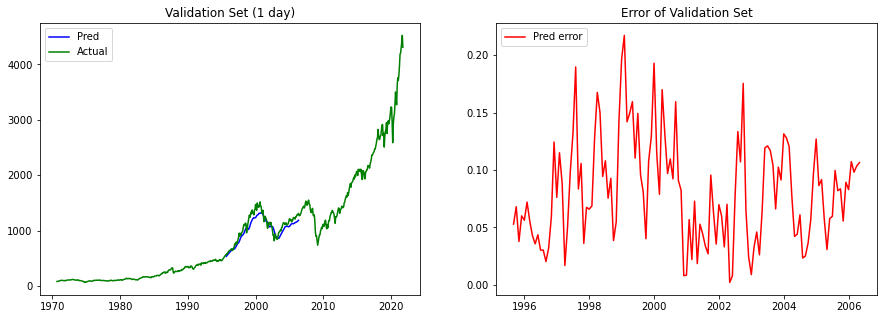

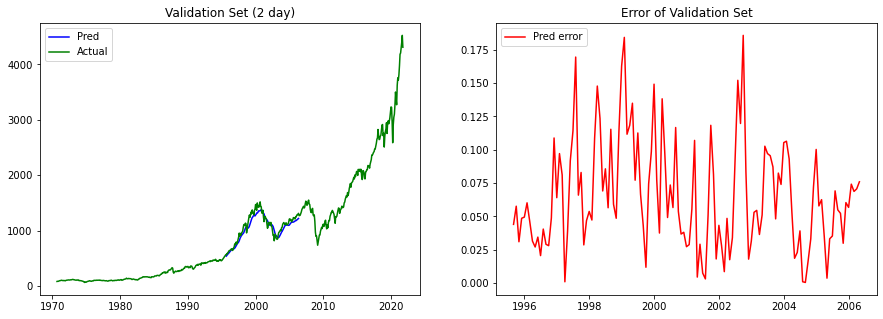

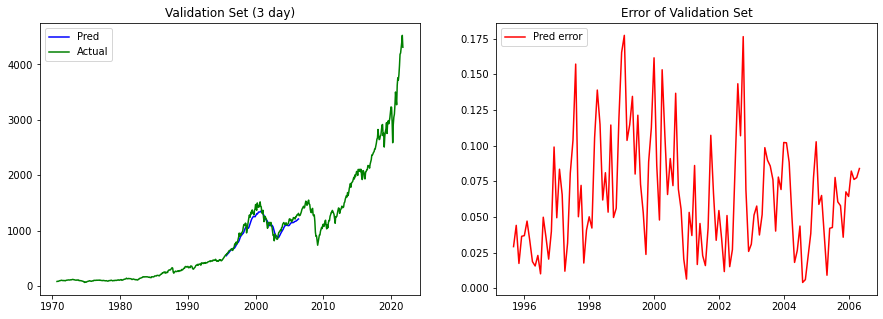

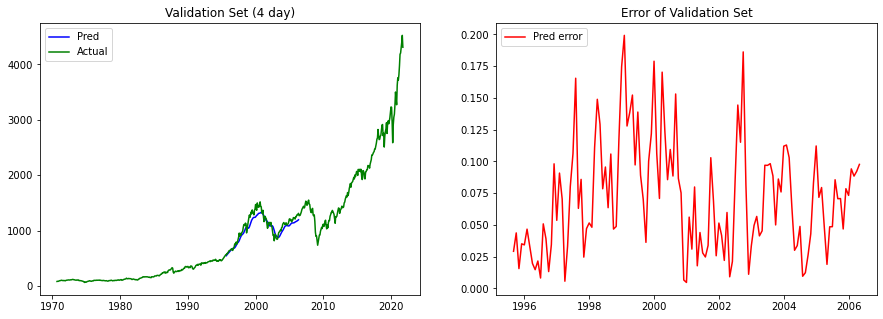

In [17]:
table = []

error = prediction_error(output_plt1, Y_validationplt)
error_dt = pd.DataFrame(data = error)
temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp1 = np.array(temp1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Validation Set (1 day)")
ax1.plot(date_v, output_plt1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Validation Set")
ax2.plot(date_v, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt2, Y_validationplt)
error_dt = pd.DataFrame(data = error)
temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp2 = np.array(temp2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Validation Set (2 day)")
ax1.plot(date_v, output_plt2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Validation Set")
ax2.plot(date_v, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt3, Y_validationplt)
error_dt = pd.DataFrame(data = error)
temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp3 = np.array(temp3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Validation Set (3 day)")
ax1.plot(date_v, output_plt3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Validation Set")
ax2.plot(date_v, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt4, Y_validationplt)
error_dt = pd.DataFrame(data = error)
temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp4 = np.array(temp4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Validation Set (4 day)")
ax1.plot(date_v, output_plt4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Validation Set")
ax2.plot(date_v, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")


temp1 = np.expand_dims(temp1, axis=1)
temp2 = np.expand_dims(temp2, axis=1)
temp3 = np.expand_dims(temp3, axis=1)
temp4 = np.expand_dims(temp4, axis=1)
table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
col = ['1 day', '2 day', '3 day', '4 day']
stats=pd.DataFrame(table, columns=col, index=ind).T
stats

In [18]:
xTensor = torch.from_numpy(X_test).float()
output, _ = RNNval(xTensor)

output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_testplt = norm.inverse_transform(Y_test[:, :, 0])

Mean   STD-dev  Skewness  Kurtosis
1 day  0.265466  0.204413  1.302686  1.421072
2 day  0.201580  0.160778  1.429360  1.877817
3 day  0.234265  0.186794  1.262341  1.206313
4 day  0.285917  0.241075  1.388131  1.656725

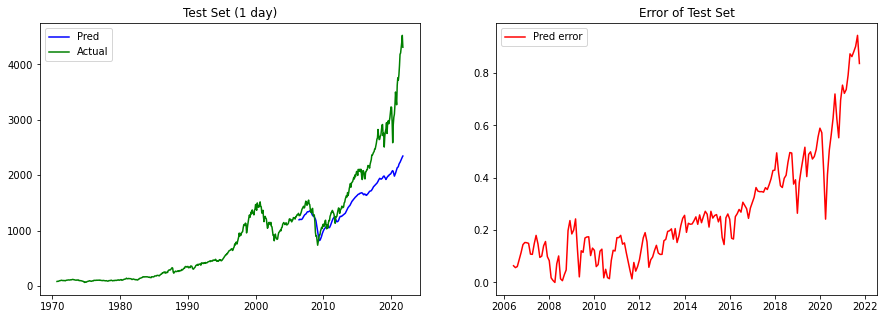

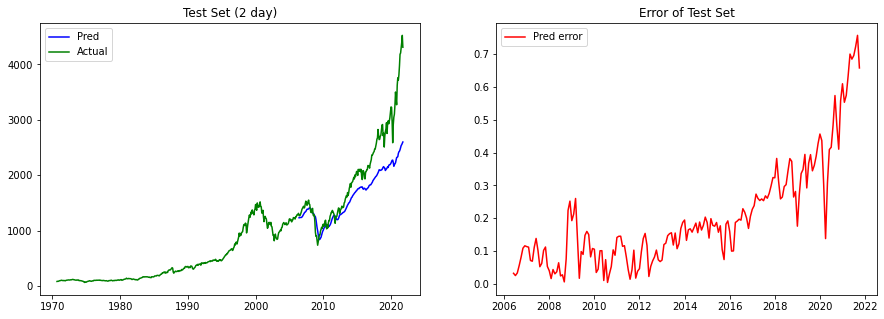

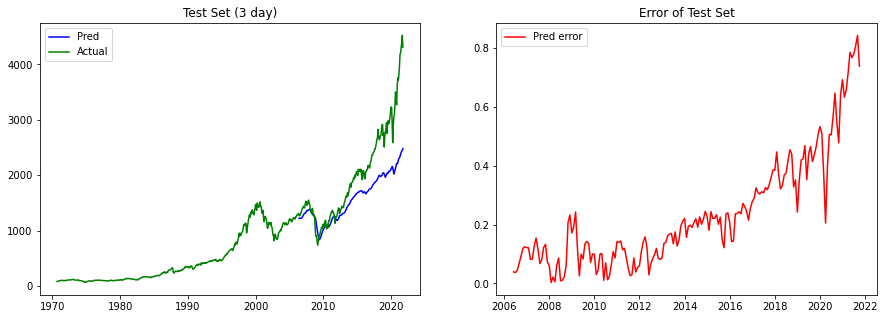

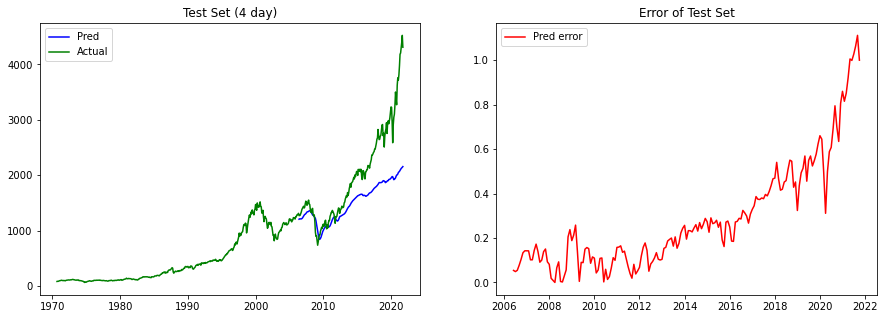

In [19]:
table = []

error = prediction_error(output_plt1, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp1 = np.array(temp1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (1 day)")
ax1.plot(date_t, output_plt1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt2, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp2 = np.array(temp2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (2 day)")
ax1.plot(date_t, output_plt2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt3, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp3 = np.array(temp3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (3 day)")
ax1.plot(date_t, output_plt3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt4, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp4 = np.array(temp4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (4 day)")
ax1.plot(date_t, output_plt4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")


temp1 = np.expand_dims(temp1, axis=1)
temp2 = np.expand_dims(temp2, axis=1)
temp3 = np.expand_dims(temp3, axis=1)
temp4 = np.expand_dims(temp4, axis=1)
table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
col = ['1 day', '2 day', '3 day', '4 day']
stats=pd.DataFrame(table, columns=col, index=ind).T
stats

# Step 6

In [20]:
def predict(day_index):
    out_temp = np.concatenate( (Y_test[:, :, day_index], Y_test[:, :, day_index], Y_test[:, :, day_index]), axis = 1)
    target = norm.inverse_transform(out_temp)[:, [0]]
    error_res_all = []
    for sigma in stdev:
        noisy_data = NoisyTesting(X_test, sigma)
        inputs = Variable(torch.from_numpy(noisy_data).float())
        output, _ = RNNval(inputs)
        out_temp = np.concatenate((output.detach().numpy()[:, [day_index]], 
                                   output.detach().numpy()[:, [day_index]],  
                                   output.detach().numpy()[:, [day_index]]), axis=1)
        predicted_price = norm.inverse_transform(out_temp)[:, [0]]
        error = prediction_error(target, predicted_price)
        error_res_all.append(error.reshape(-1))
    return error_res_all

In [21]:
cmaps= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue' ]
def FullGraphing(day):
    plt.figure(1, figsize=(15, 5))
    for i in range(len(stdev)): 
        #print(np.shape(date_test))
        #print(np.shape(error_res_all[i]))
        #print(np.shape(cmaps[i]))
        plt.plot(np.squeeze(date_test), error_res_all[i], color=cmaps[i], lw=1, label = stdev[i], marker= 'o', linestyle='None')  

    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next ' +day+ ' day)')
    plt.legend(loc="lower right") 

In [22]:
def IndividualGraphing(day):
    for i in range(len(stdev)): 
        plt.figure(1, figsize=(15, 5))
        plt.plot(np.squeeze(date_test), error_res_all[i], color=cmaps[i], lw=1, label = stdev[i], marker= 'o', linestyle='None')  
        plt.xlabel('Date')
        plt.ylabel('Prediction error')
        plt.title('Prediction error with Different Noise Levels (next '+day+' day)')
        plt.legend(loc="lower right")  
        plt.show()

In [23]:
print("NOISY")
stdev = [0,0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05,0.1]

def NoisyTesting(dataset, sigma):
    noisy_data = np.ndarray(shape=dataset.shape, dtype=np.float32)
    #set seed for random numbers
    random.seed(1)
    for i in range(6):
        s = np.random.normal(0, sigma, 18)
        index = random.sample(list(range(180)), 18)
        noisy_data[i] = dataset[i]
        noisy_data[index, i, 0] = noisy_data[index, i, 0] + s
    return noisy_data

NOISY


0.000     0.001     0.002     0.003     0.005     0.010  \
01/08/2006  0.060001  0.060104  0.060289  0.059702  0.060840  0.061806   
01/09/2006  0.053680  0.053680  0.053680  0.053680  0.053680  0.053680   
01/10/2006  0.057388  0.057388  0.057388  0.057388  0.057388  0.057388   
01/11/2006  0.080185  0.079964  0.080630  0.080263  0.079481  0.079149   
01/12/2006  0.102248  0.102248  0.102248  0.102248  0.102248  0.102248   
...              ...       ...       ...       ...       ...       ...   
01/08/2021  0.984640  0.984640  0.984640  1.023356  0.984640  1.023356   
01/09/2021  0.984974  0.984974  0.984974  1.022930  0.984974  1.022930   
01/10/2021  0.985308  0.985308  0.985308  1.022333  0.985308  1.022333   
01/11/2021  0.985722  0.985722  0.985722  1.021781  0.985722  1.021781   
01/12/2021  0.985009  0.985009  0.985009  1.022858  0.985009  1.022858   

               0.020     0.030     0.050     0.100  
01/08/2006  0.063183  0.057177  0.061676  0.065189  
01/09/2006  0.053680  0.053680  0.053680  0.053680  
01/10/2006  0.057388  0.057388  0.057388  0.057388  
01/11/2006  0.085676  0.080665  0.053548  0.044617  
01/12/2006  0.102248  0.102248  0.102248  0.102248  
...              ...       ...       ...       ...  
01/08/2021  0.984640  1.023356  0.984640  1.023356  
01/09/2021  0.984974  1.022930  0.984974  1.022930  
01/10/2021  0.985308  1.022333  0.985308  1.022333  
01/11/2021  0.985722  1.021781  0.985722  1.021781  
01/12/2021  0.985009  1.022858  0.985009  1.022858  

[185 rows x 10 columns]

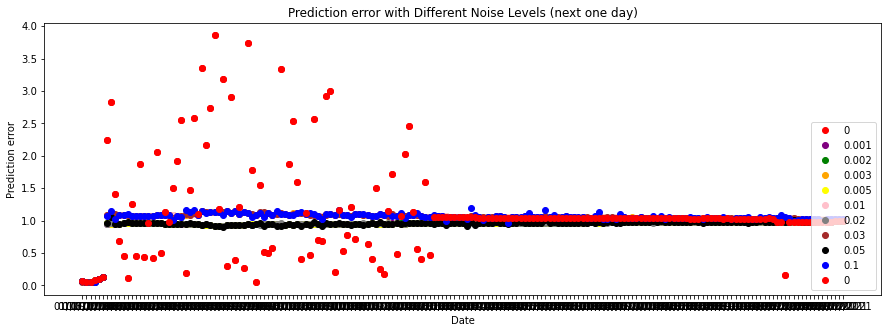

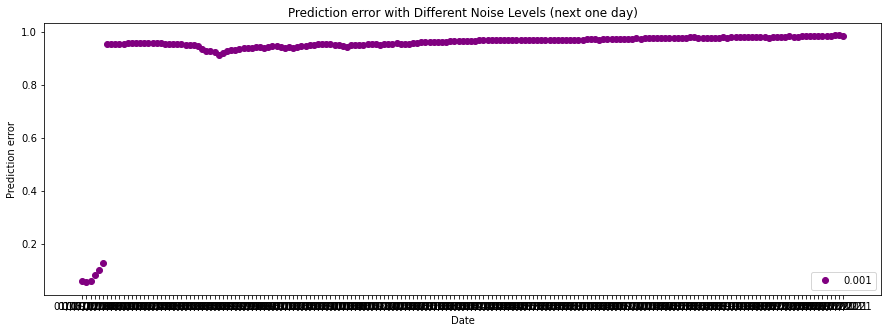

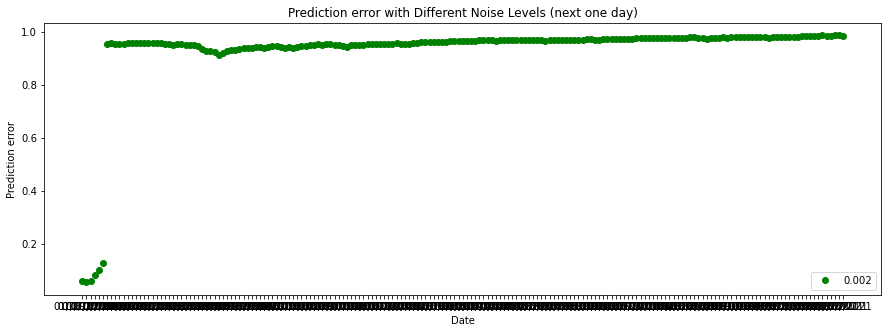

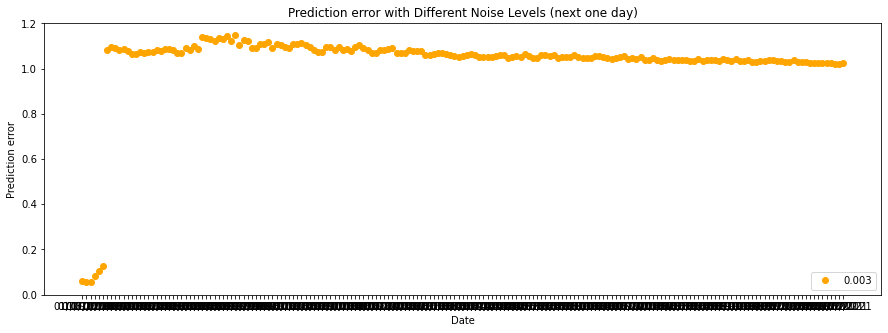

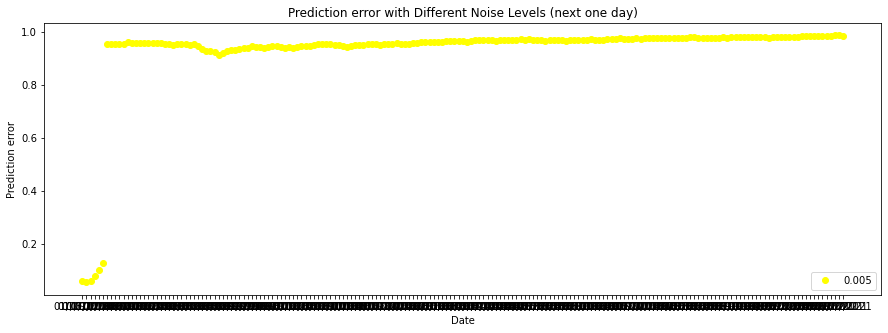

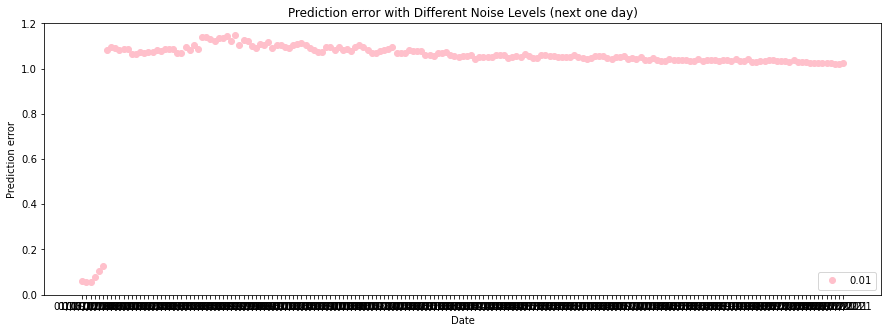

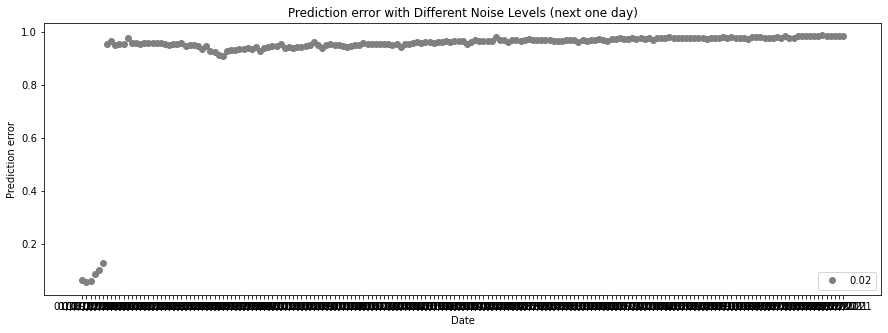

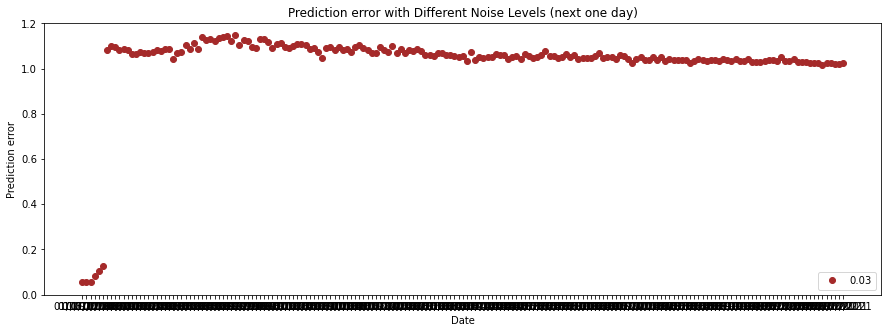

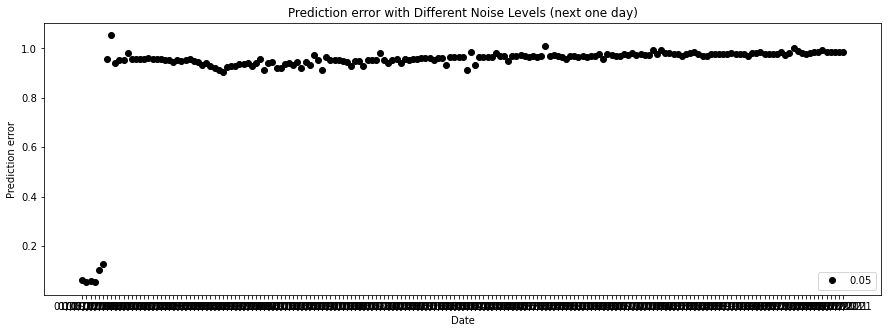

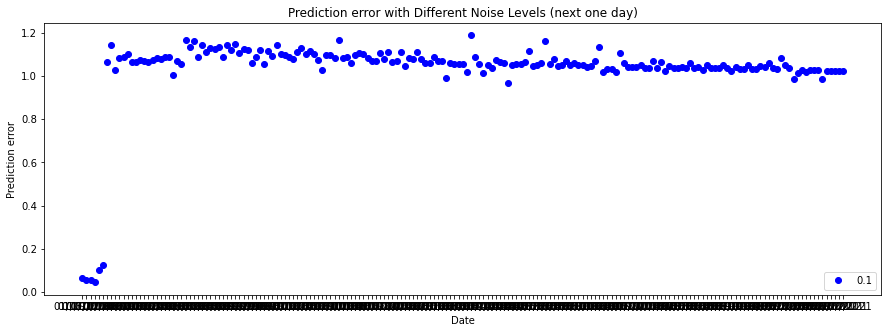

In [24]:
error_res_all=predict(0)

labels = date_test[:,0]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdev).T
display(df_error)

FullGraphing("one")
IndividualGraphing("one")

0.000     0.001     0.002     0.003     0.005     0.010  \
01/08/2006  0.031462  0.031448  0.030489  0.031371  0.031609  0.028249   
01/09/2006  0.029724  0.029724  0.029724  0.029724  0.029724  0.029724   
01/10/2006  0.052463  0.052463  0.052463  0.052463  0.052463  0.052463   
01/11/2006  0.075632  0.075616  0.074311  0.075941  0.079594  0.078490   
01/12/2006  0.103195  0.103195  0.103195  0.103195  0.103195  0.103195   
...              ...       ...       ...       ...       ...       ...   
01/08/2021  1.019388  0.984895  1.019388  0.984895  1.019388  0.984895   
01/09/2021  1.018982  0.985231  1.018982  0.985231  1.018982  0.985231   
01/10/2021  1.018447  0.985647  1.018447  0.985647  1.018447  0.985647   
01/11/2021  1.019355  0.984930  1.019355  0.984930  1.019355  0.984930   
01/12/2021  1.018114  0.985905  1.018114  0.985905  1.018114  0.985905   

               0.020     0.030     0.050     0.100  
01/08/2006  0.032792  0.028001  0.039018  0.032608  
01/09/2006  0.029724  0.029724  0.029724  0.029724  
01/10/2006  0.052463  0.052463  0.052463  0.052463  
01/11/2006  0.066189  0.087158  0.047524  0.034063  
01/12/2006  0.103195  0.103195  0.103195  0.103195  
...              ...       ...       ...       ...  
01/08/2021  1.024676  0.984895  1.019388  0.984895  
01/09/2021  0.985231  0.985231  1.018982  0.985231  
01/10/2021  0.985647  0.985647  1.018447  0.985647  
01/11/2021  1.007868  0.984930  1.019355  0.984930  
01/12/2021  1.011790  0.985905  1.018114  0.985905  

[185 rows x 10 columns]

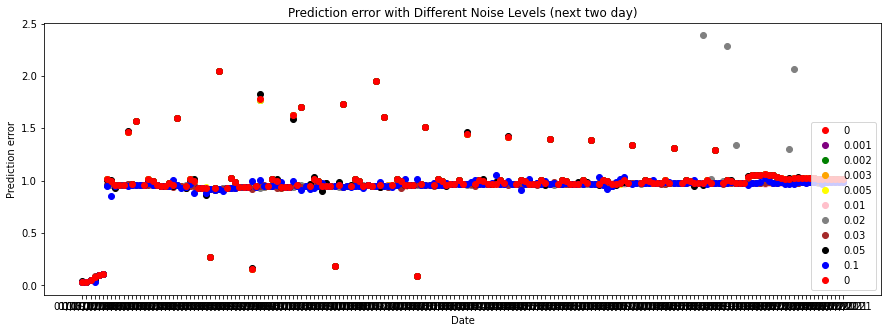

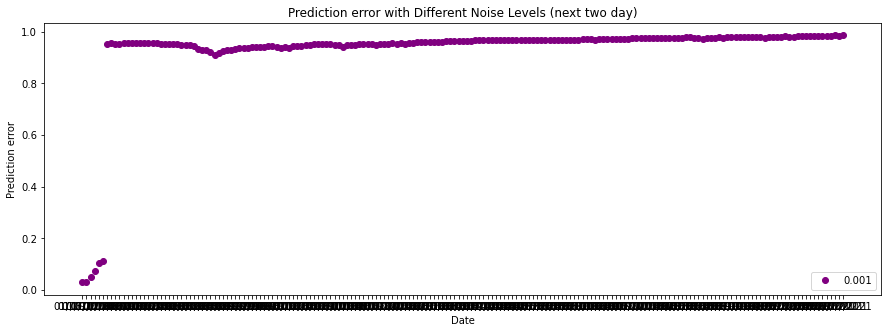

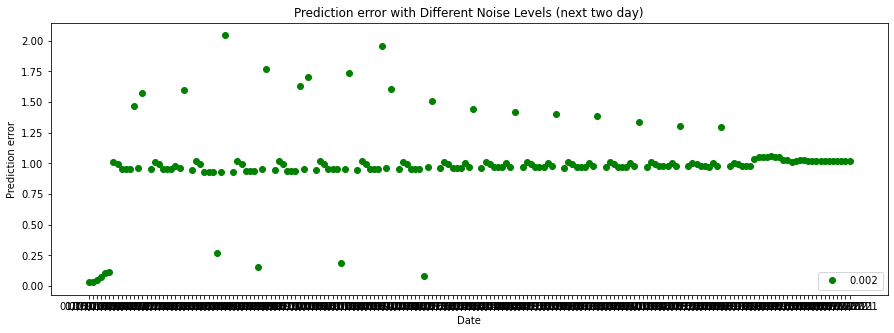

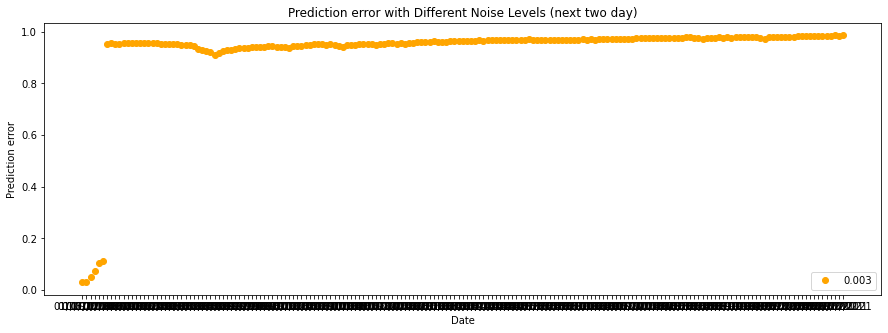

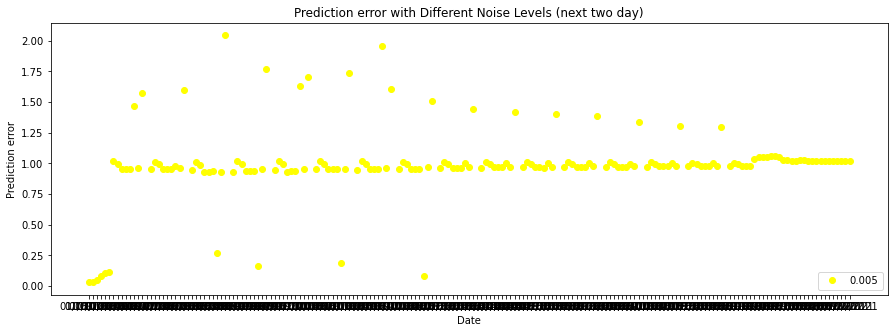

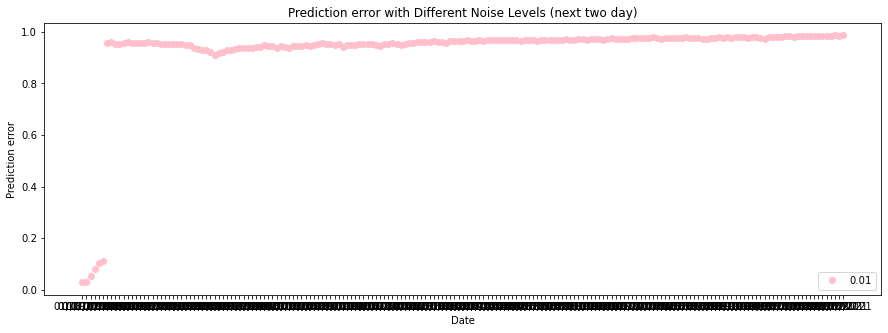

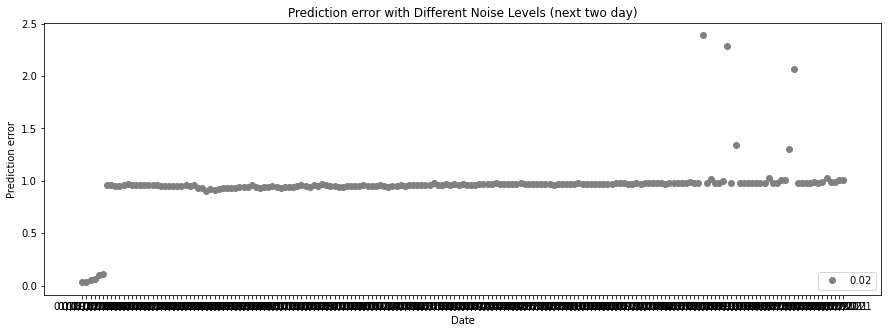

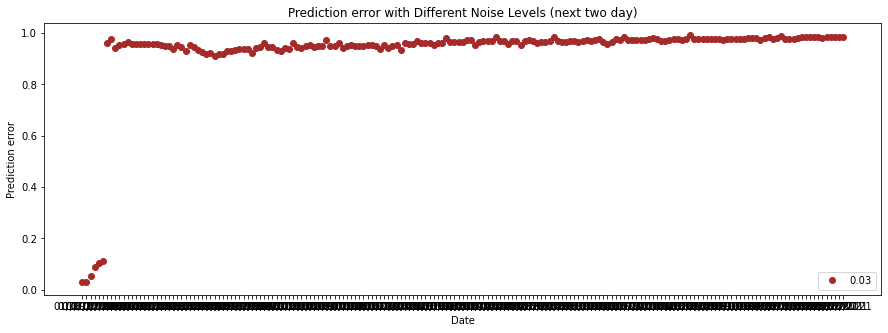

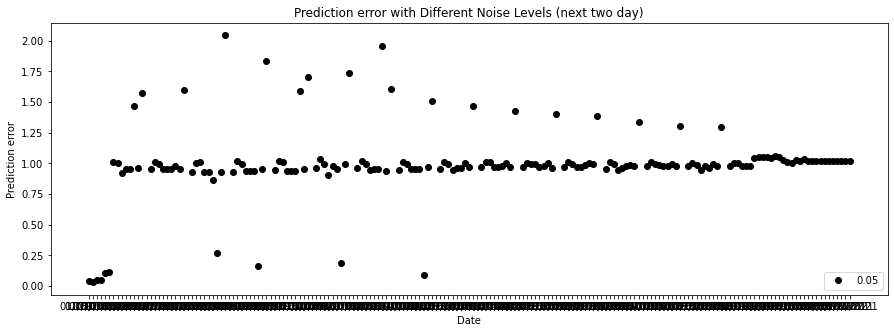

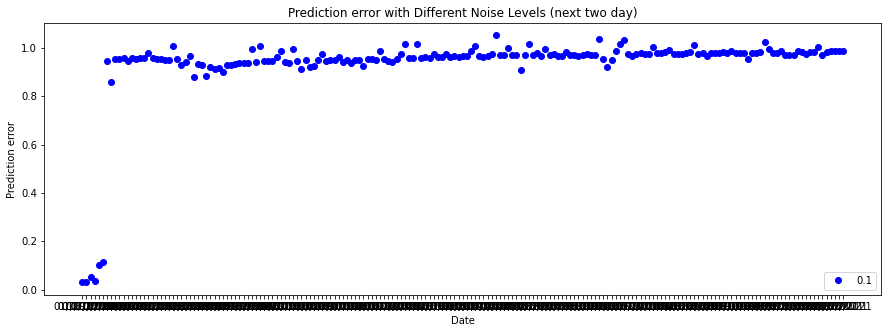

In [25]:
error_res_all=predict(1)

output.detach().numpy()[:,0:1]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdev).T
display(df_error)

FullGraphing("two")
IndividualGraphing("two")

0.000     0.001     0.002     0.003     0.005     0.010  \
01/08/2006  0.042948  0.043069  0.043023  0.042540  0.042312  0.041852   
01/09/2006  0.060029  0.060029  0.060029  0.060029  0.060029  0.060029   
01/10/2006  0.085313  0.085313  0.085313  0.085313  0.085313  0.085313   
01/11/2006  0.114284  0.112506  0.115251  0.114415  0.114043  0.119034   
01/12/2006  0.127495  0.127495  0.127495  0.127495  0.127495  0.127495   
...              ...       ...       ...       ...       ...       ...   
01/08/2021  0.048267  1.709895  0.985094  0.048267  1.029204  0.048267   
01/09/2021  0.052832  0.437469  0.985849  0.052832  0.985514  0.052832   
01/10/2021  0.059143  1.439756  1.013912  0.059143  0.984790  0.059143   
01/11/2021  0.173605  1.797766  0.985774  0.173605  0.569087  0.173605   
01/12/2021  0.431757  0.640845  0.985654  0.431757  1.022320  0.431757   

               0.020     0.030     0.050     0.100  
01/08/2006  0.040779  0.044039  0.045237  0.024542  
01/09/2006  0.060029  0.060029  0.060029  0.060029  
01/10/2006  0.085313  0.085313  0.085313  0.085313  
01/11/2006  0.149526  0.146467  0.155993  0.122013  
01/12/2006  0.127495  0.127495  0.127495  0.127495  
...              ...       ...       ...       ...  
01/08/2021  0.985094  0.036909  1.029204  0.437797  
01/09/2021  0.986408  0.136882  0.985514  0.409092  
01/10/2021  1.013912  0.074982  0.984790  0.039902  
01/11/2021  0.985774  0.435610  0.569087  1.418321  
01/12/2021  0.985654  0.135785  1.022320  0.131256  

[185 rows x 10 columns]

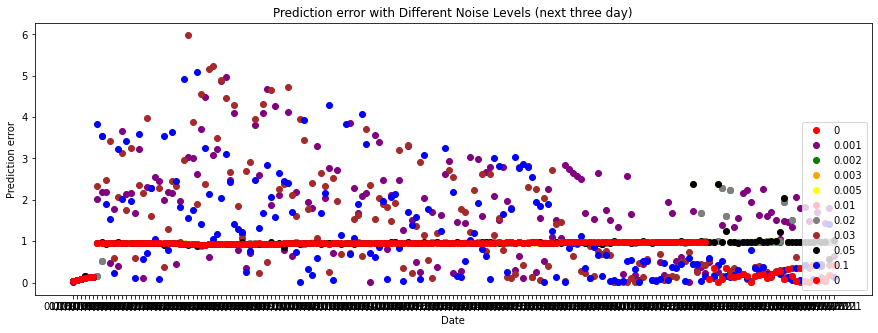

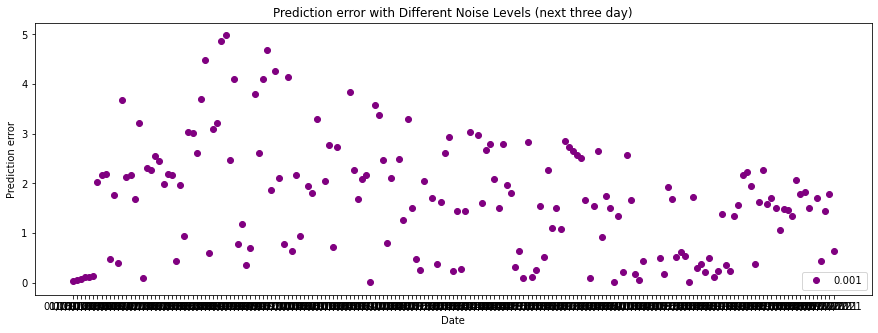

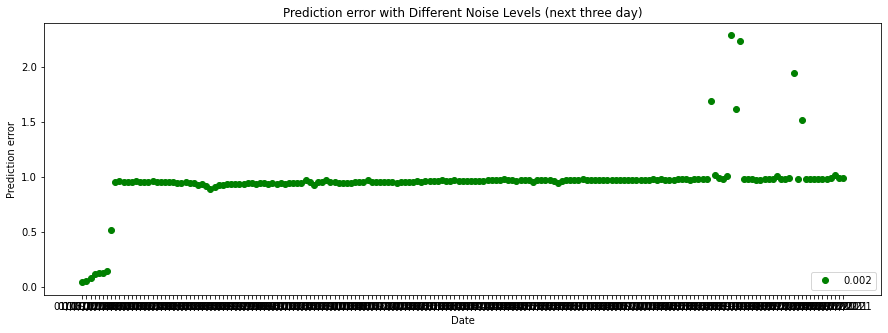

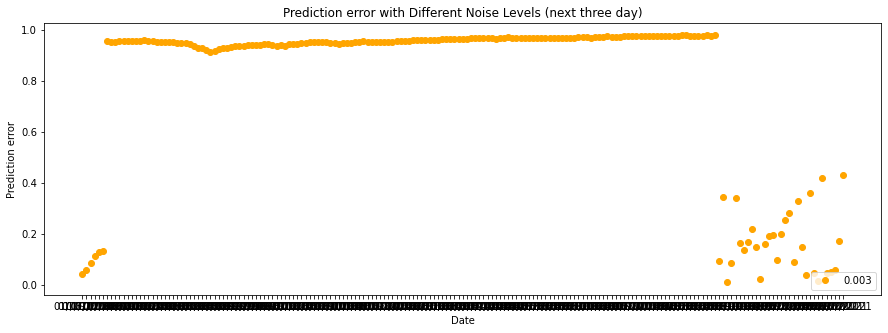

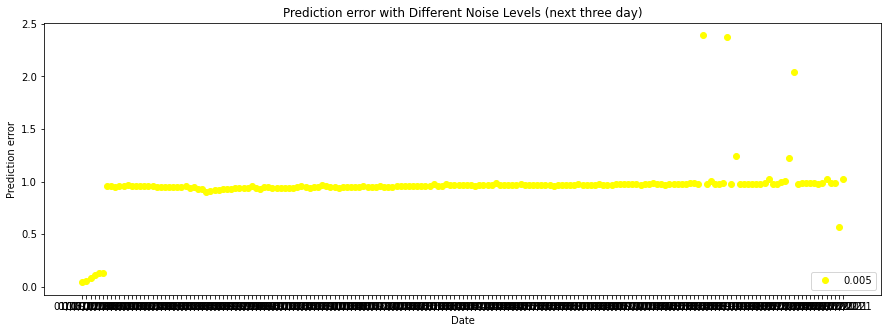

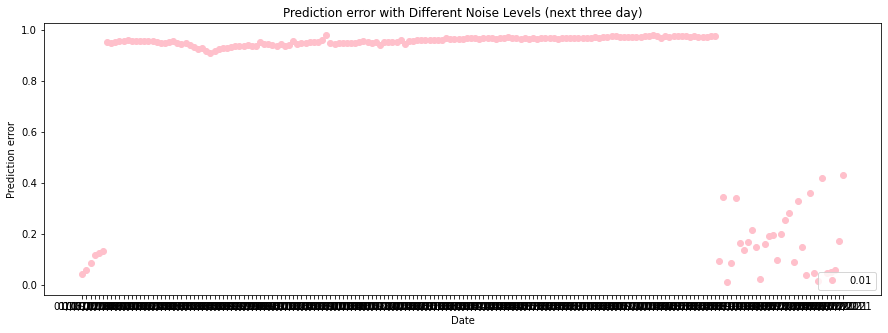

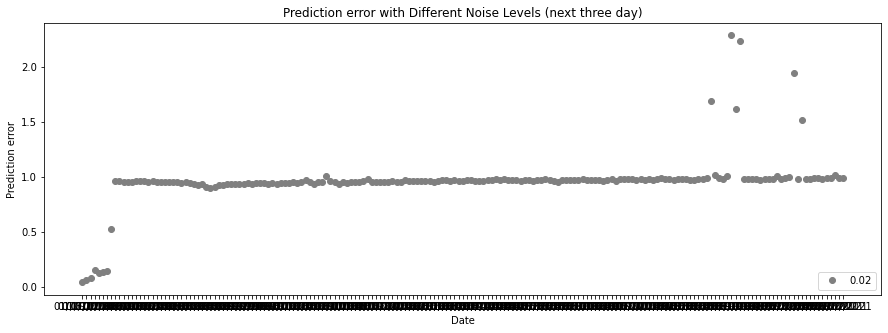

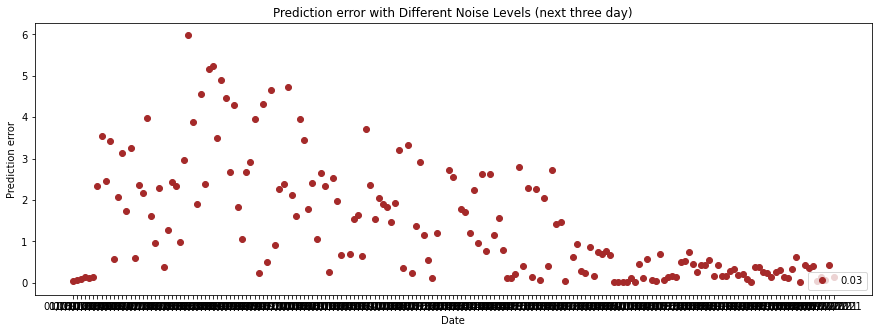

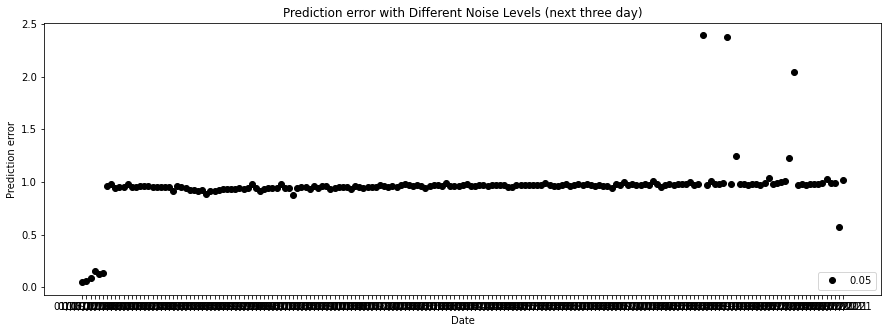

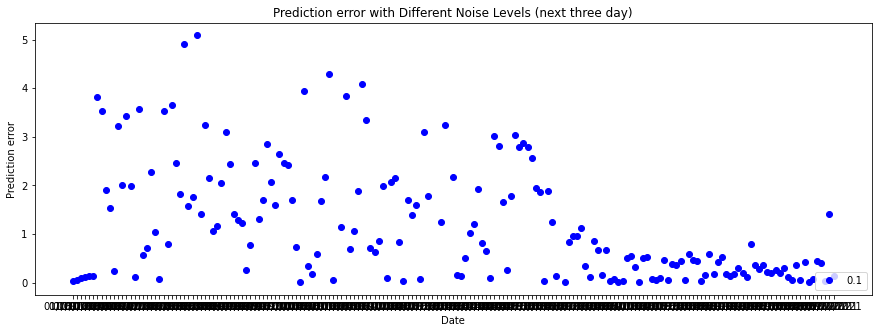

In [26]:
error_res_all=predict(2)

output.detach().numpy()[:,0:2]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdev).T
display(df_error)

FullGraphing("three")
IndividualGraphing("three")

0.000     0.001     0.002     0.003     0.005     0.010  \
01/08/2006  0.075962  0.075928  0.076053  0.076066  0.076555  0.075707   
01/09/2006  0.093578  0.093578  0.093578  0.093578  0.093578  0.093578   
01/10/2006  0.121589  0.121589  0.121589  0.121589  0.121589  0.121589   
01/11/2006  0.136119  0.136331  0.136845  0.135010  0.134593  0.131946   
01/12/2006  0.146664  0.146664  0.146664  0.146664  0.146664  0.146664   
...              ...       ...       ...       ...       ...       ...   
01/08/2021  0.985552  0.985552  0.985552  0.985552  0.985552  0.985552   
01/09/2021  0.984830  0.984830  0.984830  0.984830  0.984830  0.984830   
01/10/2021  0.985863  0.985811  0.985863  0.985811  0.985863  0.985811   
01/11/2021  0.756360  0.985692  0.756360  0.985692  0.756360  0.985692   
01/12/2021  0.660905  0.986290  0.660905  0.986290  0.660905  0.986290   

               0.020     0.030     0.050     0.100  
01/08/2006  0.075360  0.076919  0.078220  0.080500  
01/09/2006  0.093578  0.093578  0.093578  0.093578  
01/10/2006  0.121589  0.121589  0.121589  0.121589  
01/11/2006  0.129419  0.143136  0.120834  0.183873  
01/12/2006  0.146664  0.146664  0.146664  0.146664  
...              ...       ...       ...       ...  
01/08/2021  0.985552  0.985552  0.985552  0.985552  
01/09/2021  0.984830  0.984830  0.984830  0.984830  
01/10/2021  0.985863  0.985811  0.985863  0.985811  
01/11/2021  0.756360  0.985692  0.756360  0.985692  
01/12/2021  0.660905  0.986290  0.660905  0.986290  

[185 rows x 10 columns]

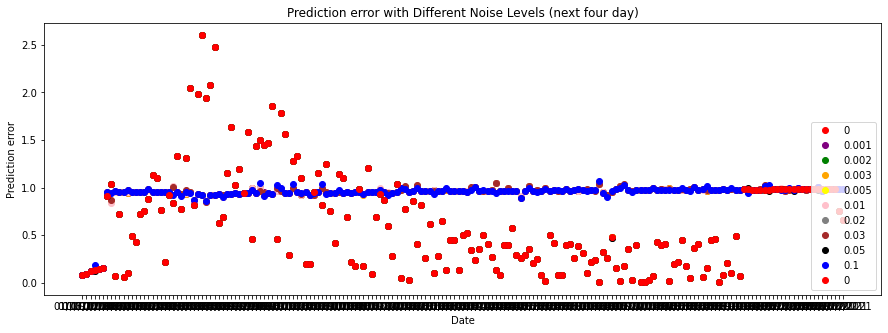

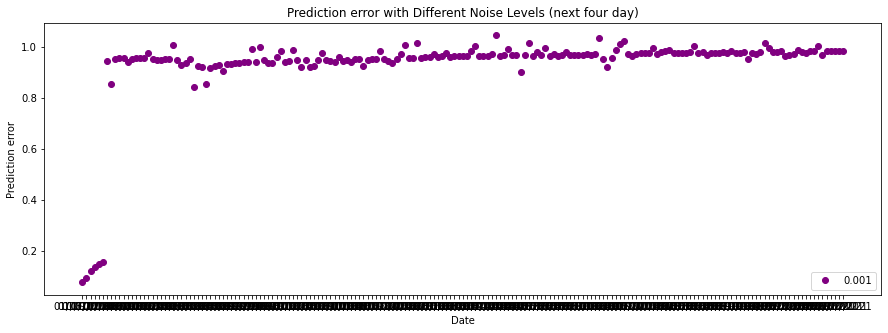

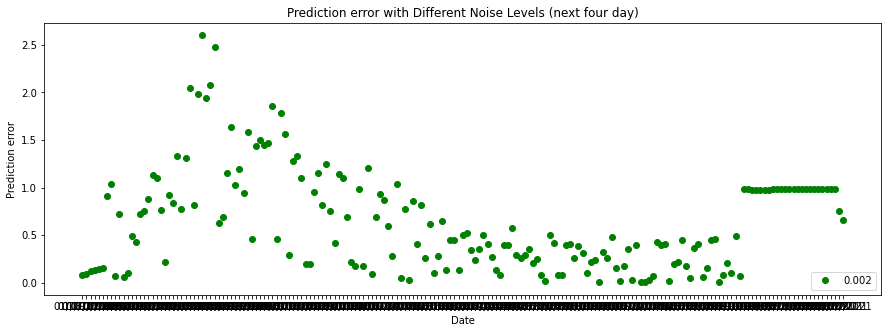

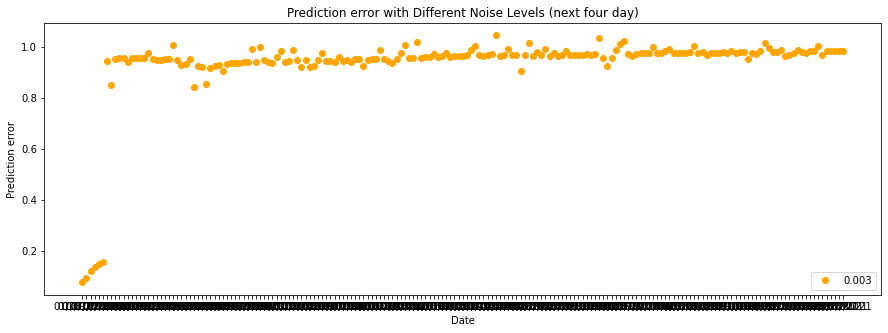

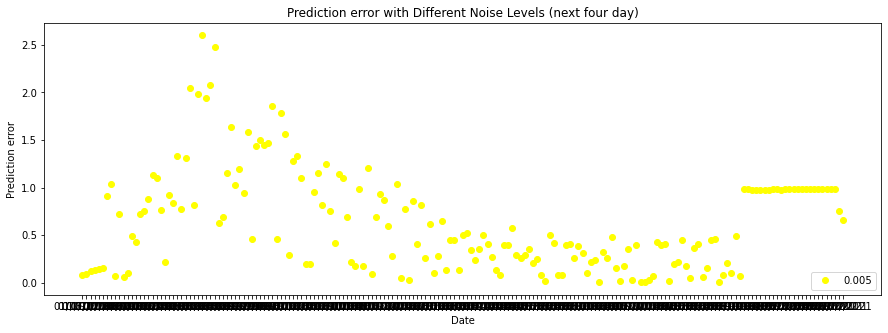

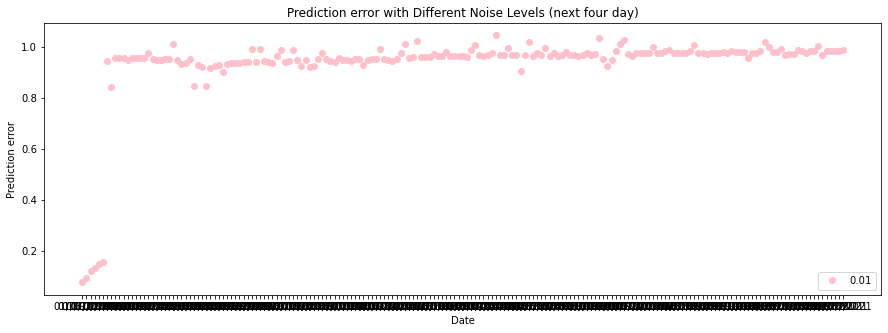

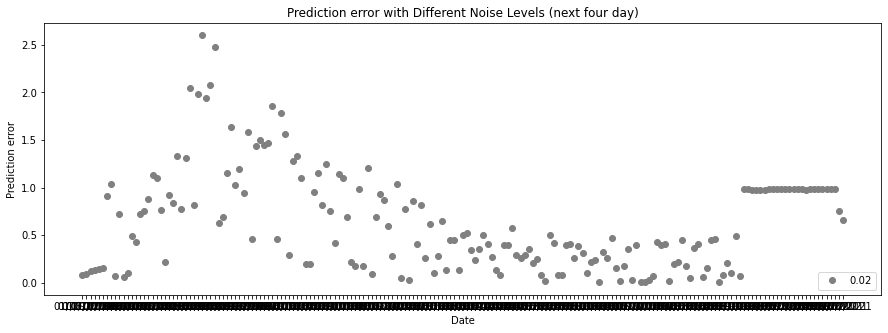

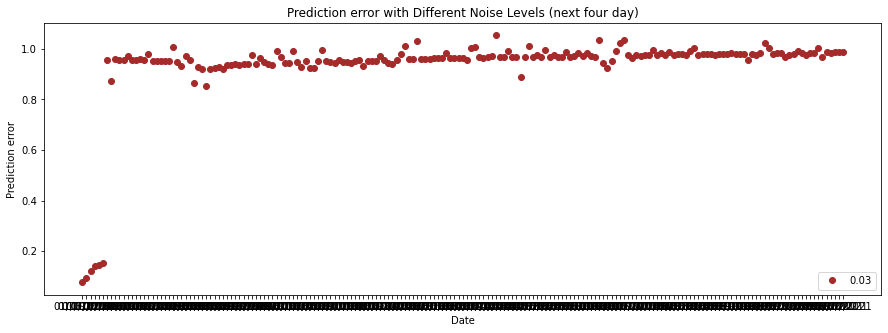

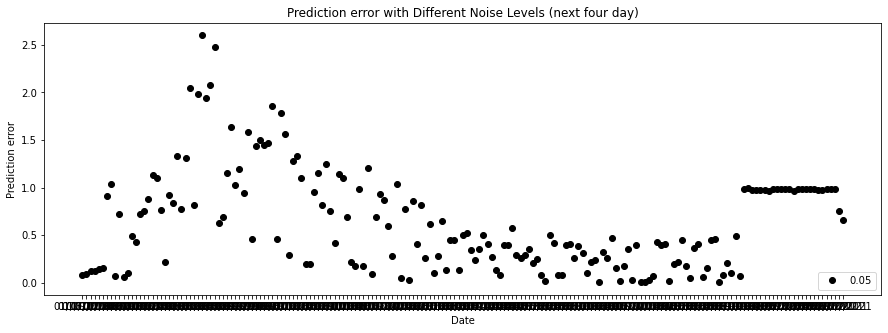

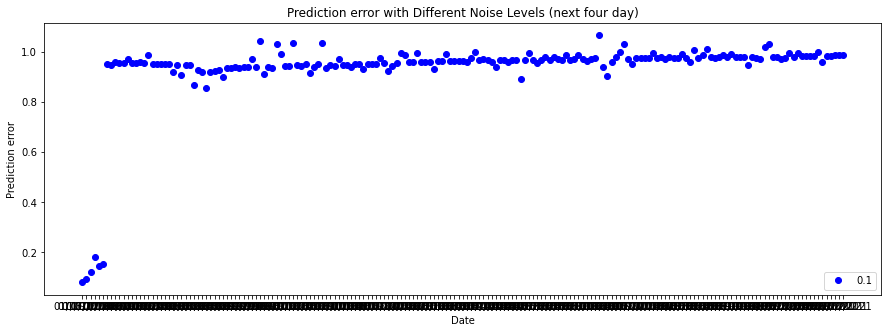

In [27]:
error_res_all=predict(3)

output.detach().numpy()[:,0:3]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdev).T
display(df_error)

FullGraphing("four")
IndividualGraphing("four")